# Libraries

In [1]:
# standard
import pandas as pd
import numpy as np
from tqdm import tqdm
import math
from math import sqrt
import time

# reading data
import os
import json
from collections import defaultdict

# machine learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.fft import rfft, irfft, fftn, ifftn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

# visuals
import matplotlib.pyplot as plt
import seaborn as sns

# measuring ressources
import time
import psutil
import GPUtil
import threading

# eFormer
from eFormer.embeddings import Encoding, ProbEncoding, PositionalEncoding
from eFormer.sparse_attention import ProbSparseAttentionModule, DetSparseAttentionModule
from eFormer.loss_function import CRPS, weighted_CRPS
from eFormer.sparse_decoder import DetSparseDecoder, ProbSparseDecoder
from eFormer.Dataloader import TimeSeriesDataProcessor

# transformer Benchmarks
from Benchmarks.models.Informer import Model as Informer 
from Benchmarks.models.Autoformer import Model as Autoformer
from Benchmarks.models.Transformer import Model as VanillaTransformer
from Benchmarks.data_provider.data_loader import Dataset_Custom


%store -r Kelmarsh_df Penmanshiel_df

# Hyperparameters

In [2]:
# set global parameters
hyperparameters = {
    'n_heads': 4,
    'ProbabilisticModel': False,
    # embeddings
    'len_embedding': 64,
    'batch_size': 512,
    # eFormer
    'pred_len': 1,
    'seq_len': 72,
    'patience': 7,
    'dropout': 0.05,
    # models general
    'learning_rate': 6e-4,
    'WeightDecay': 1e-1,
    'train_epochs': 5,
    # benchmarks
    'Frequency': '10min',
    'label_len': 36,
    'root_path': '../data/Windturbinen/Kelmarsh/',
    'data_path': 'Kelmarsh_1.csv',
    'freq': 't',
    'activation': 'relu',
    'loss': 'CRPS',
    'use_gpu': True,  # Adjusted based on torch.cuda.is_available()
    'gpu': 0,
    'use_multi_gpu': False,  # Since store_true is used, the default is False
    'devices': '0,1,2,3'
    }

hyperparameters.update({
    'is_training': 1,
    'model_id': 'test',
    'features': 'M',
    'target': 'OT',
    'checkpoints': './checkpoints/',
    'bucket_size': 4,
    'n_hashes': 4,
    'enc_in': 3,
    'dec_in': 3,
    'c_out': 3,
    'd_model': 512,
    'e_layers': 2,
    'd_layers': 1,
    'd_ff': 2048,
    'moving_avg': 25,
    'factor': 1,
    'distil': True,  # Note: This reverses the default argparse behavior because store_false is used
    'embed': 'timeF',
    'output_attention': False,  # Since store_true is used, the default is False
    'do_predict': False,  # Since store_true is used, the default is False
    'num_workers': 10,
    'itr': 2,
    'des': 'test',
    'lradj': 'type1',
    'use_amp': False,  # Since store_true is used, the default is False
})

# Adjusting use_gpu based on torch.cuda.is_available()
hyperparameters['use_gpu'] = torch.cuda.is_available() and hyperparameters['use_gpu']

# Parsing device IDs for multi-GPU setup
if hyperparameters['use_gpu'] and hyperparameters['use_multi_gpu']:
    device_ids = hyperparameters['devices'].replace(' ', '').split(',')
    hyperparameters['device_ids'] = [int(id_) for id_ in device_ids]
    hyperparameters['gpu'] = hyperparameters['device_ids'][0]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Ressource Management

In [3]:
def check_system_conditions():
    # Get CPU usage for each core
    cpu_percent = round(psutil.cpu_percent(), 4)

    # Get memory information
    memory_info = psutil.virtual_memory()
    memory_used_gb = round(memory_info.used / (1024 ** 3), 4)

    # Get GPU information
    try:
      gpu_info = GPUtil.getGPUs()[0]
      gpu_memory_used_gb = round(gpu_info.memoryUsed / 1024, 4)
    except IndexError:
      # If no GPU is found, set variables to None
      gpu_memory_used_gb = None

    # Collect data in a dictionary
    comp_usage = {
        'CPU Usage': cpu_percent,
        'Memory Usage (GB)': memory_used_gb,
        'GPU Usage (GB)': gpu_memory_used_gb
    }

    return comp_usage

# Load Data

In [4]:
def shifted_data(data, forecast, look_back):
    data = data.set_index('# Date and time')
    data.index.names = [None]
    data = data.drop(['Long Term Wind (m/s)'], axis=1)
    shifts = range(forecast, look_back + forecast)
    variables = data.columns
        
    shifted_columns = []
    for column in variables:
        for i in shifts:
            shifted_df = data[[column]].shift(i)
            shifted_df.rename(columns={column: f"{column} (lag {i})"}, inplace=True)
            shifted_columns.append(shifted_df)
        
    data = data.drop(['Wind speed (m/s)'], axis=1)
    data_shifted = pd.concat([data] + shifted_columns, axis=1)
    data_shifted.dropna(inplace=True)
        
    return data_shifted

In [5]:
data = Kelmarsh_df['1']
data = data.set_index('# Date and time')
data.index.names = [None]
data = data.drop(['Long Term Wind (m/s)'], axis=1)

# Transformer Model

In [6]:
# Assuming `df` is your initial DataFrame
processor = TimeSeriesDataProcessor(
    dataframe=data,
    forecast=hyperparameters['pred_len'],
    look_back=hyperparameters['seq_len'],
    batch_size=hyperparameters['batch_size'])
    
train_loader, test_loader, eval_loader = processor.create_dataloaders()

In [7]:
for batch in train_loader:
    features, labels = batch
    break

%store features labels

Stored 'features' (Tensor)
Stored 'labels' (Tensor)


In [8]:
class eFormer(nn.Module):
    def __init__(self, d_model, in_features, len_embedding_vector, n_heads_global, probabilistic_model=False):
        super(eFormer, self).__init__()
        self.probabilistic_model = probabilistic_model
        self.n_heads_global = n_heads_global
        self.len_embedding_vector = len_embedding_vector

        # Initialize encoding model
        if probabilistic_model:
            self.encoding_model = ProbEncoding(in_features=in_features, out_features=len_embedding_vector)
        else:
            self.encoding_model = Encoding(in_features=in_features, out_features=len_embedding_vector)

        # Initialize attention module
        if probabilistic_model:
            self.attention_module = ProbSparseAttentionModule(d_model=d_model, n_heads=n_heads_global, prob_sparse_factor=5)
        else:
            self.attention_module = DetSparseAttentionModule(d_model=d_model, n_heads=n_heads_global, prob_sparse_factor=5)

        # Initialize decoder
        # Assuming the decoder initialization does not actually require the output shape directly but parameters that depend on the model configuration
        if probabilistic_model:
            self.decoder = ProbSparseDecoder(d_model=d_model, n_heads=n_heads_global, forecast_horizon=1, encoder_output_dim=len_embedding_vector)
        else:
            self.decoder = DetSparseDecoder(d_model=d_model, n_heads=n_heads_global, forecast_horizon=1, encoder_output_dim=len_embedding_vector)

    def forward(self, features_matrix):
        if torch.isnan(features_matrix).any():
            raise ValueError('NaN values detected in Input')

        embeddings = self.encoding_model(features_matrix)
        if torch.isnan(embeddings).any():
            raise ValueError('NaN values detected in Embeddings')

        encoder_output = self.attention_module(embeddings, embeddings, embeddings)
        if torch.isnan(encoder_output).any():
            raise ValueError('NaN values detected in Sparse Attention Output')

        forecasts, crps_weights = self.decoder(encoder_output)
        return forecasts, crps_weights

In [9]:
# Single Layer Perceptron Model
class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        x = self.linear(x)
        weights = self.linear.weight.data
        
        return x, weights

In [10]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0
            if self.verbose:
                print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f})')
            self.val_loss_min = val_loss

In [11]:
# initiate model etc
early_stopping = EarlyStopping(
    patience=hyperparameters['patience'],
    verbose=True
    )
model = eFormer(
    in_features=(hyperparameters['seq_len'] * 2),
    d_model=hyperparameters['d_model'],
    len_embedding_vector=hyperparameters['len_embedding'],
    n_heads_global=hyperparameters['n_heads'],
    probabilistic_model=hyperparameters['ProbabilisticModel']).to(device)
"""
model = LinearModel(
    input_size=(hyperparameters['seq_len'] * 2),
    output_size=hyperparameters['pred_len'],
).to(device)
"""
optimizer = AdamW(
    params = model.parameters(),
    lr=hyperparameters['learning_rate'],
    weight_decay=hyperparameters['WeightDecay']
    )
loss_fn = CRPS()
num_epochs = hyperparameters['train_epochs']

# function to run monitoring in a separate thread
def monitor_system_usage(every_n_seconds=10, keep_running=lambda: True, results_list=[]):
    while keep_running():
        comp_usage = check_system_conditions()
        results_list.append(comp_usage)
        time.sleep(every_n_seconds)

# Initialize a list to store the results
system_usage_results = []

# Define a lambda function to control the monitoring loop
keep_monitoring = lambda: keep_monitoring_flag
keep_monitoring_flag = True # Initialize the flag before starting training

# Start the monitoring thread
monitor_thread = threading.Thread(target=monitor_system_usage, args=(5, keep_monitoring, system_usage_results))
monitor_thread.start()

for epoch in range(num_epochs):
    epoch_start_time = time.time()
    model.train()
    train_losses = []
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()
        predictions, crps_weights = model(features)
        loss = loss_fn(predictions, labels)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    train_loss_avg = np.mean(train_losses)
    print(f"Epoch {epoch + 1} / {num_epochs} with Loss: {round(train_loss_avg, 6)}")

    # Validation phase
    model.eval()
    validation_losses = []
    predictions_collected = []
    groundtruth_collected = []
    batches_collected = 0  # Counter to keep track of the batches
    with torch.no_grad():
        for features, labels in eval_loader:
            features, labels = features.to(device), labels.to(device)
            predictions, crps_weights = model(features)
            val_loss = loss_fn(predictions, labels)
            validation_losses.append(val_loss.item())

            if batches_collected >= 10:
                pass  # Exit loop after collecting from 10 batches
            else:
                predictions_collected.extend(predictions.tolist())
                groundtruth_collected.extend(labels.tolist())
                batches_collected += 1

    val_loss_avg = np.mean(validation_losses)
    print(f"Validation Loss: {round(val_loss_avg, 6)}")

    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time
    print(f"Epoch Duration: {round(epoch_duration, 4)}s")

    early_stopping(val_loss_avg)
    if early_stopping.early_stop:
        print("Early stopping")
        break

# After training is done, set the flag to False to stop the monitoring thread
keep_monitoring_flag = False
monitor_thread.join()  # Wait for the monitoring thread to finish

# Convert the results list to a DataFrame
system_usage_df = pd.DataFrame(system_usage_results)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (512x64 and 512x512)

In [49]:
print(f"Average CPU Usage: \n {round(system_usage_df['CPU Usage'][1:].mean(), 4)} %")
print(f"Average RAM Usage: \n {round(system_usage_df['Memory Usage (GB)'].mean(), 4)} GB")
if system_usage_df['GPU Usage (GB)'][0] == None:
    print(f"No GPU used")
else:
    print(f"Average GPU Usage: \n {round(system_usage_df['GPU Usage (GB)'][1:].mean(), 4)} GB")

Average CPU Usage: 
 67.0143 %
Average RAM Usage: 
 8.745 GB
No GPU used


# Visualization

In [50]:
df_eval = pd.DataFrame({
    'Predictions':[item for sublist in predictions_collected for item in sublist],
    'GroundTruth':groundtruth_collected
    })

In [51]:
def prediction_graph(df):
    # Set the style
    sns.set(style="whitegrid")

    # Create a larger plot
    plt.figure(figsize=(12, 6))

    # Plot Predictions
    sns.lineplot(x=df.index, y='Predictions', data=df, label='Predictions', color='darkorange', linewidth=0.5)

    # Plot GroundTruth on the same plot
    sns.lineplot(x=df.index, y='GroundTruth', data=df, label='Ground Truth', color='dimgrey', linewidth=.5)

    # Adding some aesthetics
    plt.title('Comparison of Predictions and Ground Truth')
    plt.xlabel('Time Stamps')  # Assuming the DataFrame index is a suitable x-axis
    plt.ylabel('Value')
    plt.legend()  # This ensures we have a legend for our two lines

    # Show plot
    plt.tight_layout()
    plt.show()

prediction_graph(df_eval[:1000])

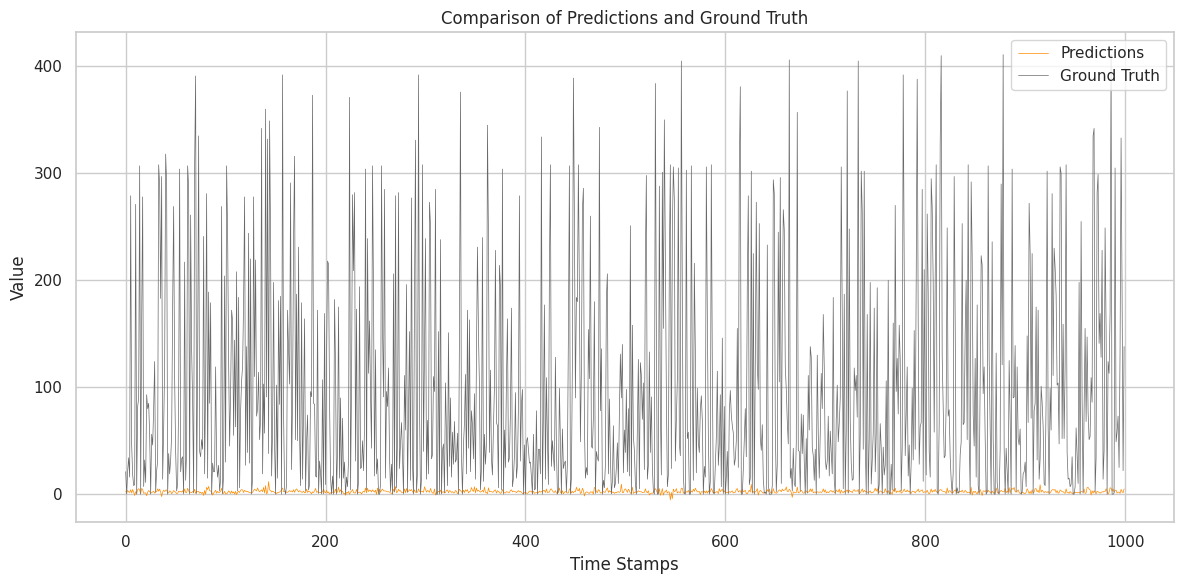

In [52]:
prediction_graph(df_eval[:1000])

# Benchmark Models

## DataLoader

seperate inputs for Time stamps and values

In [13]:
Kelmarsh_df['1'].columns

Index(['# Date and time', 'Wind speed (m/s)', 'Long Term Wind (m/s)',
       'Energy Export (kWh)'],
      dtype='object')

In [51]:
Kelmarsh_df['1'].rename(columns={'# Date and time':'date'}, inplace=True)

Kelmarsh_df['1'].to_csv('../data/Windturbinen/Kelmarsh/Kelmarsh_1.csv', encoding='utf-8', index=False)

# Initialize your custom dataset
dataset = Dataset_Custom(
    root_path=hyperparameters['root_path'],
    data_path=hyperparameters['data_path'],
    target='Energy Export (kWh)',
    features='M',
    size=[hyperparameters['seq_len'], hyperparameters['seq_len'], hyperparameters['pred_len']],
    freq=hyperparameters['Frequency']
    )

# Create a DataLoader
benchmark_dataloader = DataLoader(
    dataset,
    batch_size=hyperparameters['batch_size'],
    shuffle=False
    )

# Example of iterating over your DataLoader
for batch in benchmark_dataloader:
    x_enc, x_dec, seq_x_enc, seq_x_dec = batch
    # Your training code here
    break



In [55]:
seq_x_enc[0][0][0]

tensor(6)

## vanilla Transformer

In [39]:
class Config:
    def __init__(self, dictionary):
        for key, value in dictionary.items():
            setattr(self, key, value)

# Convert the hyperparameters dictionary to a Config object
hyperparameters_class = Config(hyperparameters)

# Initialize model, optimizer, and loss function here
model = VanillaTransformer(configs=hyperparameters_class)  # Adjust this line based on actual model initialization
optimizer = AdamW(model.parameters(), lr=hyperparameters['learning_rate'], weight_decay=hyperparameters['WeightDecay'])
loss_fn = CRPS()  # Ensure CRPS is correctly implemented

num_epochs = hyperparameters['train_epochs']

for epoch in range(num_epochs):
    model.train()
    epoch_losses = []

    for batch in benchmark_dataloader:
        x_enc, x_mark_enc, x_dec, x_mark_dec = batch
        # Assuming `x_dec` contains your target values `batch_y` in this context
        # And assuming the structure of `x_dec` is [batch, seq_len, feature_dim]
        
        # Prepare decoder input similar to the snippet provided
        dec_inp = torch.zeros_like(x_dec[:, -hyperparameters_class.pred_len:, :]).float()
        dec_inp = torch.cat([x_dec[:, :hyperparameters_class.label_len, :], dec_inp], dim=1).float().to(device)
        
        # Move to device
        x_enc, x_mark_enc, x_dec, x_mark_dec = x_enc.to(device), x_mark_enc.to(device), x_dec.to(device), x_mark_dec.to(device)
        
        # Forward pass
        outputs = model(x_enc, x_mark_enc, dec_inp, x_mark_dec)
        if hyperparameters_class.output_attention:
            outputs = outputs[0]  # Assume the first output is the prediction
        
        # Selecting the predicted features
        f_dim = -1 if configs.features == 'MS' else 0
        outputs = outputs[:, -hyperparameters_class.pred_len:, f_dim:]
        y_true = x_dec[:, -hyperparameters_class.pred_len:, f_dim:].to(device)
        
        # Compute loss
        loss = loss_function(outputs, y_true)
        
        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_losses.append(loss.item())
    
    print(f'Epoch {epoch+1}/{n_epochs}, Average Loss: {np.mean(epoch_losses)}')


RuntimeError: expected scalar type Double but found Float

# Test Area

In [38]:
def CRPS_test(forecast, observations):
    # Cumulative sum of sorted forecasts
    cumsum_forecast = torch.cumsum(forecast, dim=0) / forecast.size(0)
    print(cumsum_forecast)

    # Calculating CRPS
    indicator = (forecast > 0).float()
    print(indicator)
    differences = (cumsum_forecast - indicator) ** 2
    print(differences)
    crps = differences.mean()

    return crps

CRPS_test(torch.tensor(df_eval['Predictions']), torch.tensor(df_eval['GroundTruth']))

tensor([3.1156e-04, 5.6105e-04, 8.8270e-04,  ..., 1.5851e+00, 1.5854e+00,
        1.5858e+00], dtype=torch.float64)
tensor([1., 1., 1.,  ..., 1., 1., 1.])
tensor([0.9994, 0.9989, 0.9982,  ..., 0.3423, 0.3427, 0.3432],
       dtype=torch.float64)


tensor(0.2526, dtype=torch.float64)

In [8]:
%run Benchmarks/run.py \
  --is_training 1 \
  --root_path ../data/Windturbinen/Kelmarsh/ \
  --data_path Kelmarsh_1.csv \
  --target 'Energy Export (kWh)' \
  --model_id VanillaTransformer_quick \
  --model Transformer \
  --data custom \
  --features M \
  --seq_len 96 \
  --label_len 48 \
  --pred_len 96 \
  --e_layers 2 \
  --d_layers 1 \
  --factor 3 \
  --enc_in 1 \
  --dec_in 1 \
  --c_out 1 \
  --des 'Exp' \
  --itr 1


Args in experiment:
Namespace(is_training=1, model_id='VanillaTransformer_quick', model='Transformer', data='custom', root_path='../data/Windturbinen/Kelmarsh/', data_path='Kelmarsh_1.csv', features='M', target='Energy Export (kWh)', freq='h', checkpoints='./checkpoints/', seq_len=96, label_len=48, pred_len=96, bucket_size=4, n_hashes=4, enc_in=1, dec_in=1, c_out=1, d_model=512, n_heads=8, e_layers=2, d_layers=1, d_ff=2048, moving_avg=25, factor=3, distil=True, dropout=0.05, embed='timeF', activation='gelu', output_attention=False, do_predict=False, num_workers=10, itr=1, train_epochs=10, batch_size=32, patience=3, learning_rate=0.0001, des='Exp', loss='mse', lradj='type1', use_amp=False, use_gpu=False, gpu=0, use_multi_gpu=False, devices='0,1,2,3')
Use CPU
>>>>>>>start training : VanillaTransformer_quick_Transformer_custom_ftM_sl96_ll48_pl96_dm512_nh8_el2_dl1_df2048_fc3_ebtimeF_dtTrue_Exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
all columns: ['date', 'Wind speed (m/s)', 'Long Term Wind (m/s)', 'En

RuntimeError: Given groups=1, weight of size [512, 1, 3], expected input[32, 3, 98] to have 1 channels, but got 3 channels instead

In [ ]:
# Concatenate all DataFrames in the dictionary into a single DataFrame
Kelmarsh_full_df = pd.concat(Kelmarsh_df.values(), ignore_index=True)
Penmanshiel_full_df = pd.concat(Penmanshiel_df.values(), ignore_index=True)

Wind_df = pd.concat([Kelmarsh_full_df, Penmanshiel_full_df], ignore_index=True, sort=False)

Wind_df = Wind_df.drop('date', axis=1)

Wind_df.to_csv('../data/Windturbinen/Wind_df.csv')

# To-Do's

- ground truth and forecasted values in graph as time series
- seperate model for wind and company, one model can't output 2 different results for same equation

- label_length = look_back
- sequence_length -> window size